# Prepare the daily mean precipitation dataset from 1996 to 2022 for ML

In [3]:
import os
import netCDF4
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools 

In [4]:
from platform import python_version
import sys
print('Python: ' + python_version()) # Python: 3.12.2
print('netCDF4: ' + netCDF4.__version__) # netCDF4: 1.6.5
print('pandas: ' + pd.__version__) # pandas: 2.2.1
print('numpy: ' + np.__version__) # numpy: 1.26.4
print ('matplotlib: ' + sys.modules["matplotlib"].__version__) # matplotlib: 3.8.3
print('seaborn: ' + sns.__version__) # seaborn: 0.13.2

Python: 3.12.2
netCDF4: 1.6.5
pandas: 2.2.1
numpy: 1.26.4
matplotlib: 3.8.3
seaborn: 0.13.2


## Load the daily mean precipitation dataset from 1996 to 2022

In [5]:
Datasetpath = "datasets_daily/dataset-satellite-precipitation-large/"

In [6]:
file2read = netCDF4.Dataset(Datasetpath+'gpcp_v01r03_daily_d20200101_c20200408.nc','r')
latitude = np.array(file2read.variables["latitude"][:])
longitude = np.array(file2read.variables["longitude"][:])
longitude = (longitude + 180) % 360 - 180

In [7]:
dataset_list = os.listdir(Datasetpath)
len(dataset_list)

9404

In [8]:
List_time = []
datacube_precip = None
temp = np.argsort(longitude)
for dataset in dataset_list:
    file2read = netCDF4.Dataset(Datasetpath+dataset,'r')
    List_time.append(datetime.date.fromtimestamp(int(file2read.variables["time"][0]*24*60*60)).strftime('%Y%m%d'))
    if datacube_precip is not None:
        datacube_precip = np.concatenate((datacube_precip, file2read.variables["precip"][:,:,temp]), axis=0)
    else:
        datacube_precip = file2read.variables["precip"][:,:,:]
longitude.sort()

### save data as np.array in .npy file format

In [9]:
# convert the masked array to np.array
datacube_precip = datacube_precip.data

In [10]:
np.save("./data/WaterPrecip_datacube_large.npy", datacube_precip)

In [11]:
# convert the time value to int
List_time = np.array(list(map(int, List_time)))

In [12]:
np.save("./data/WaterPrecip_time_large.npy", List_time)

In [13]:
np.save("./data/WaterPrecip_latitude.npy", latitude)
np.save("./data/WaterPrecip_longitude.npy", longitude)

In [14]:
time = np.load("./data/WaterPrecip_time_large.npy")

# Get missing values

In [15]:
temp_nMissing = []
temp_max_Val = []
for i, x in enumerate(datacube_precip.min(axis = (1,2)) < -1):
    if x:
        temp_nMissing.append(sum(datacube_precip[i,:,:].flatten() < -1))
        temp_max_Val.append(max(datacube_precip[i,:,:].flatten()))
idx_missingVal = pd.DataFrame(data= {'Date': List_time[datacube_precip.min(axis = (1,2)) < -1], 
                                     'index': [i for i, x in enumerate(datacube_precip.min(axis = (1,2)) < -1) if x], 
                                     'nMissing': temp_nMissing, 
                                     'max_Val': temp_max_Val})

In [16]:
print(idx_missingVal)

         Date  index  nMissing     max_Val
0    19980109    465       103   86.302559
1    19980110    466       109  105.335381
2    19980111    467        52   66.128906
3    19981116    776        18   83.341217
4    19981218    808         2   94.983139
..        ...    ...       ...         ...
167  20220404   9316     36000    0.000000
168  20220405   9317     36000    0.000000
169  20220406   9318     36000    0.000000
170  20220407   9319     10940   94.238518
171  20220413   9325       198   79.945358

[172 rows x 4 columns]


## Normalize outliers

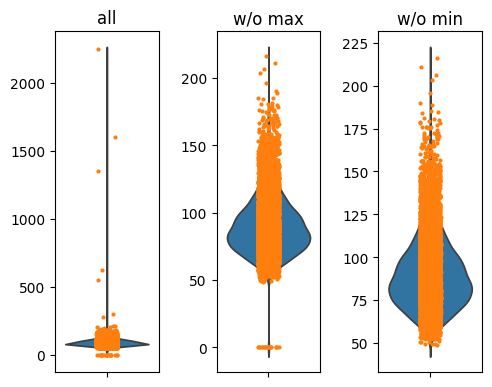

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(5,4), gridspec_kw={'width_ratios': [1, 1, 1]})
fig.tight_layout()
# Due to the large size of the dataset not all points could be plotted
# Aggregate by time slices with max
axs[0].set_title('all')
sns.violinplot(datacube_precip.max(axis = (1,2)), inner=None, ax=axs[0])
sns.stripplot(datacube_precip.max(axis = (1,2)), size = 3, ax=axs[0])
# 7 points are greater than 250 mm/d
# Exclude the outlier
axs[1].set_title('w/o max')
temp = datacube_precip[datacube_precip.max(axis = (1,2)) < 250,:,:]
sns.violinplot(temp.max(axis = (1,2)), inner=None, ax=axs[1])
sns.stripplot(temp.max(axis = (1,2)), size = 3, ax=axs[1])
# Time slices that have no values have 0 as max value
# Exclude slices that contains missing values
axs[2].set_title('w/o min')
temp = temp[temp.min(axis = (1,2)) > -1,:,:]
sns.violinplot(temp.max(axis = (1,2)), inner=None, ax=axs[2])
sns.stripplot(temp.max(axis = (1,2)), size = 3, ax=axs[2])
plt.show()

### Look into the time slices that contains values over 250 mm/day

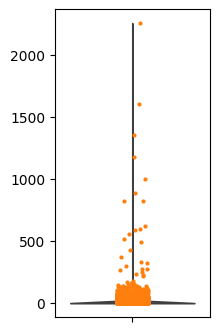

In [18]:
fig, axs = plt.subplots(figsize=(2,4))
sns.violinplot(datacube_precip[datacube_precip.max(axis = (1,2)) > 250,:,:].flatten())
sns.stripplot(datacube_precip[datacube_precip.max(axis = (1,2)) > 250,:,:].flatten(), size = 3)
plt.show()

### Values over 250 mm/day are set to 250 mm/day

In [19]:
datacube_precip[datacube_precip > 250] = 250

# Prepare data for Convolutional Neural Network (CNN) Training

### Add padding for the CNN
Under the assumption that the earth is round padding are added taking this into account

In [20]:
datacube_precip.shape

(9404, 180, 360)

In [21]:
temp_0 = datacube_precip[:,0,:]
temp_0 = np.concatenate((temp_0[:,180:], temp_0[:,:180]) , axis=1)
temp_0 = temp_0.reshape(9404,1,360)
temp_180 = datacube_precip[:,179,:]
temp_180 = np.concatenate((temp_180[:,180:], temp_180[:,:180]) , axis=1)
temp_180 = temp_180.reshape(9404,1,360)
datacube_precip = np.concatenate((temp_180, datacube_precip, temp_0), axis=1)

In [22]:
datacube_precip = np.concatenate((datacube_precip[:,:,359].reshape((9404,182,1)), datacube_precip, datacube_precip[:,:,0].reshape((9404,182,1))), axis=2)

In [23]:
datacube_precip.shape

(9404, 182, 362)

## Create the dataset for the Convolutional Autoencoder
Remove the time slices that contains missing values and reshape array to match the requirements for the ML

In [24]:
dataset_CAE_single = np.array([datacube_precip[i,:,:].reshape((182,362,1)) for i in range(datacube_precip.shape[0]) if i not in np.array(idx_missingVal["index"])])
dataset_CAE_single.shape

(9232, 182, 362, 1)

In [25]:
np.save("./data/WaterPrecip_datacube_CAE_single.npy", dataset_CAE_single)

## Create the dataset for the Prediction CNN
Remove the time slices that contains missing values and reshape array to match the requirements for the ML \
Blocks of 5 are saved as training sets

In [26]:
data_exclude = list(set(functools.reduce(lambda a, b: a+list(range(b-4,b+1)), idx_missingVal.loc[:,"index"], [])))
len(data_exclude)

574

In [27]:
dataset_CNN_x = np.array([np.transpose(datacube_precip[i:i+5,:,:], (1, 2, 0)) for i in range(datacube_precip.shape[0]-4) if i not in data_exclude])
dataset_CNN_x.shape

(8826, 182, 362, 5)

In [61]:
np.save("./data/WaterPrecip_datacube_CNN_x.npy", dataset_CNN_x)

In [28]:
# smaller dataset for quick testing
np.save("./data/WaterPrecip_datacube_CAE_testing.npy", dataset_CNN_x[:10])

### Saving slices of the dataset as true values for the prediction

In [62]:
np.save("./data/WaterPrecip_datacube_CNN_y_s0", dataset_CNN_x[:,1:181,1:361,0].reshape(8826, 180, 360, 1))
np.save("./data/WaterPrecip_datacube_CNN_y_s1", dataset_CNN_x[:,1:181,1:361,1].reshape(8826, 180, 360, 1))
np.save("./data/WaterPrecip_datacube_CNN_y_s2", dataset_CNN_x[:,1:181,1:361,2].reshape(8826, 180, 360, 1))
np.save("./data/WaterPrecip_datacube_CNN_y_s3", dataset_CNN_x[:,1:181,1:361,3].reshape(8826, 180, 360, 1))
np.save("./data/WaterPrecip_datacube_CNN_y_s4", dataset_CNN_x[:,1:181,1:361,4].reshape(8826, 180, 360, 1))